## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
#loading the libraries
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import swifter
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sb
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings(action="ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:

# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json', 'r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
f.close()
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#checking the shape of the dataframe
df.shape

(78313, 22)

In [5]:
#Checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names
df.columns=['Index', 'Type', 'Id', 'Score', 'Source', 'Zip_code',
       'Complaint_Id', 'Issue', 'Date_received',
       'State', 'Consumer_disputed', 'Product',
       'Company_response', 'Company', 'Submitted_via',
       'Date_sent_to_company', 'Company_public_response',
       'Sub_product', 'Timely',
       'Complaints', 'Sub_issue',
       'Consumer_consent_provided']
df.columns

Index(['Index', 'Type', 'Id', 'Score', 'Source', 'Zip_code', 'Complaint_Id',
       'Issue', 'Date_received', 'State', 'Consumer_disputed', 'Product',
       'Company_response', 'Company', 'Submitted_via', 'Date_sent_to_company',
       'Company_public_response', 'Sub_product', 'Timely', 'Complaints',
       'Sub_issue', 'Consumer_consent_provided'],
      dtype='object')

In [8]:
# checking shape of the dataframe and count of blanks in compliants column
print(df.shape)
len(df[df['Complaints']==''])

(78313, 22)


57241

In [9]:
#Assign nan in place of blanks in the complaints column
df['Complaints']=df['Complaints'].replace(r'^\s*$',np.nan,regex=True)
df.head()

,Index,Type,Id,Score,Source,Zip_code,Complaint_Id,Issue,Date_received,State,...,Company_response,Company,Submitted_via,Date_sent_to_company,Company_public_response,Sub_product,Timely,Complaints,Sub_issue,Consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [10]:
#Remove all rows where complaints column is nan
df=df[df['Complaints'].notna()]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleantxt(snt):
    snt=snt.lower() #making the text to lower case
    snt = re.sub("[\[].*?[\]]", "", snt)  #removing texts within square brackets
    snt = snt.translate(str.maketrans('', '', string.punctuation)) #removing the punctuations in text
    snt= re.sub("\S*\d\S*", "", snt).strip() #removing the words containing numbers
    return snt

In [12]:
df.Complaints = df.Complaints.swifter.apply(lambda x: cleantxt(x))

In [14]:
#Write your function to Lemmatize the texts-Also removing the stopwords

sw = stopwords.words('english')
def lematize(word):
    wordnet_Lemmatizer = WordNetLemmatizer()
    tokens=word_tokenize(word)
    tokens = list(filter(lambda x:x not in sw , tokens))
    word_lemmatized=[wordnet_Lemmatizer.lemmatize(word)for word in tokens]
    word_lemmatized=' '.join(word_lemmatized)
    return(word_lemmatized)  
       


In [15]:
#Calling the fuction to lemmatize the compliants column
df['Complaints_lemmatized']=df.Complaints.swifter.apply(lematize)

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=pd.DataFrame(df,columns=['Complaints','Complaints_lemmatized'])

In [17]:
#Checking the dataframe
df_clean

,Complaints,Complaints_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...


In [18]:
#Write your function to extract the POS tags 

nlp=spacy.load("en_core_web_sm",disable=['parser','ner'])
from tqdm import tqdm
Noun_pos_tag=[]
for word in tqdm(df_clean['Complaints_lemmatized'].unique()):
    doc=nlp(word)
    for tok in doc:
        if tok.pos_=='NOUN':
            Noun_pos_tag.append(tok.text)

100%|████████████████████████████████████████████████████████████████████████████| 20852/20852 [03:45<00:00, 92.51it/s]


In [19]:
#Creating a set of Noun pos words to remove duplicate words
Noun_pos_set=set(Noun_pos_tag)

In [20]:
#checking the length of the Noun pos words
len(Noun_pos_tag)

1262953

In [21]:
#Checking the length of the unique Noun pos words
len(Noun_pos_set)

16046

In [22]:
#Printing the Noun Pos words
Noun_pos_set

{'tradelinesaccounts',
 'feid',
 'news',
 'intr',
 'consolidate',
 'remit',
 'marketing',
 'anwer',
 'capture',
 'latency',
 'rolling',
 'clarity',
 'promos',
 'basis',
 'protectionsrights',
 'launch',
 'mistreating',
 'victoms',
 'employment',
 'quitclaim',
 'sobordination',
 'cotrustee',
 'swelters',
 'jeopardize',
 'inference',
 'xxxxin',
 'behaviour',
 'owning',
 'lesson',
 'settlementxxxx',
 'borderline',
 'undeliverable',
 'redundancy',
 'jobssecurity',
 'listen',
 'theree',
 'walkaway',
 'oer',
 'waif',
 'gambling',
 'recalculating',
 'georgiawill',
 'digress',
 'obamastownship',
 'instesd',
 'adress',
 'cart',
 'suggesting',
 'fluctuation',
 'graph',
 'curiosity',
 'crowdsourcecrowdfund',
 'portfolio',
 'insertion',
 'complaintthey',
 'housingwire',
 'issue',
 'solo',
 'directive',
 'drag',
 'mort',
 'launching',
 'ivb',
 'oof',
 'witch',
 'daugther',
 'pocket',
 'freight',
 'xxxxxxxxeviction',
 'stimulation',
 'loon',
 'faxbut',
 'xxxxyour',
 'amputation',
 'changeover',
 'int

In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint with Noun POS tag words.
df_clean['complaints_ex']=df_clean['Complaints'].str.split()
df_clean['complaints_ex_pos']=df_clean['complaints_ex'].swifter.apply(lambda x: [word for word in x if word in Noun_pos_set])

df_clean.drop('complaints_ex',axis=1,inplace=True) 
df_clean

,Complaints,Complaints_lemmatized,complaints_ex_pos
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat..."
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an..."
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit..."
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of..."
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,..."
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,"[being, chase, card, customer, well, decade, m..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,"[xxxxxxxx, i, xxxx, xxxx, visa, credit, card, ..."
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,"[i, xxxx, pay, understand, risk, i, chase, ban..."
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,"[i, flawless, credit, chase, credit, chase, fr..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




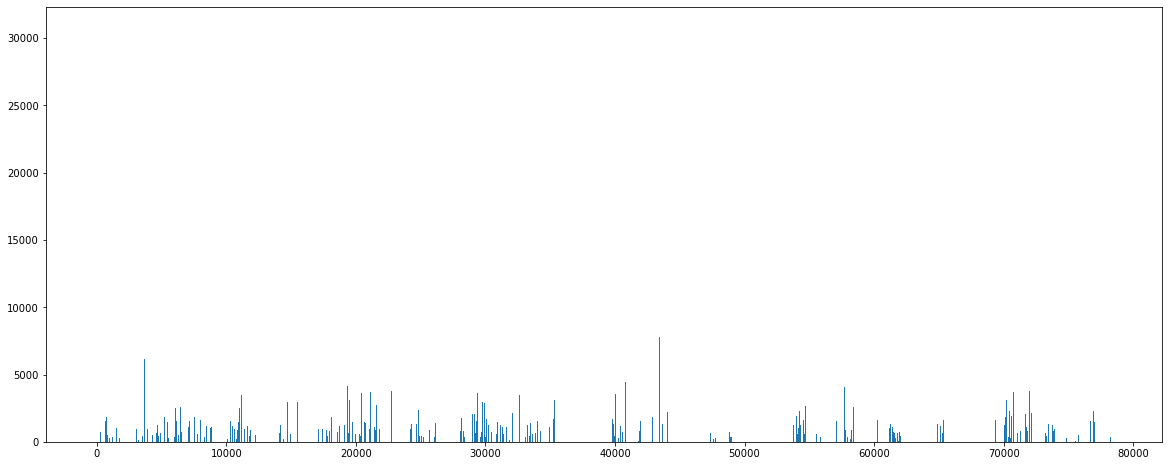

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len= df_clean['Complaints'].str.len().astype(int)
plt.figure(figsize=(20,8))
plt.bar(complaint_len.index,complaint_len)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [25]:
# Get the top 40 most common words among all the articles
p_text = df_clean['complaints_ex_pos']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 40
top_40 = pd.DataFrame(
    Counter(p_text).most_common(40),
    columns=['word', 'frequency']
)
#printing the top 40 words
top_40

,word,frequency
0,i,193732
1,xxxx,192541
2,chase,79844
3,account,42584
4,credit,32671
5,xxxxxxxx,27914
6,card,26838
7,bank,26642
8,would,20315
9,we,18375


In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#defining the wordcloud parameters
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

In [27]:
#sorting the dataframe in the ascending order
most_freq_words = top_40.sort_values(by='frequency',ascending=False).head(50)

In [28]:
#Creating a list of most frequent words
most_freq_words=most_freq_words.word.tolist()

In [29]:
#Printing the most frequent words
most_freq_words

['i',
 'xxxx',
 'chase',
 'account',
 'credit',
 'xxxxxxxx',
 'card',
 'bank',
 'would',
 'we',
 'told',
 'payment',
 'do',
 'time',
 'money',
 'back',
 'said',
 'loan',
 'check',
 'information',
 'get',
 'call',
 'letter',
 's',
 'mortgage',
 'pay',
 'number',
 'amount',
 'phone',
 'one',
 'report',
 'due',
 'balance',
 'fraud',
 'charge',
 'company',
 'being',
 'customer',
 'make',
 'dispute']

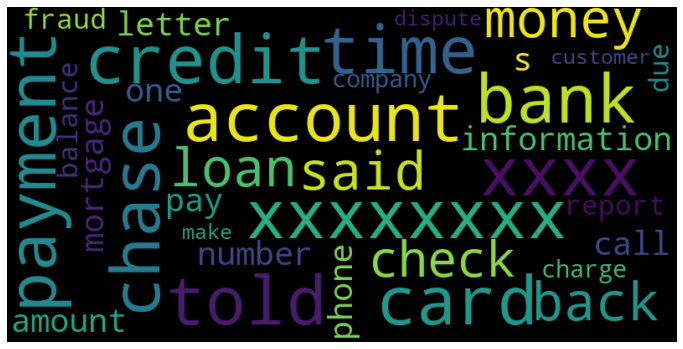

In [30]:
#Displaying the most frequent words in word cloud
wordcloud.generate(' '.join([w for w in most_freq_words]))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
#Removing -PRON- from the text corpus
df_clean['complaints_pos_joined']=df_clean['complaints_ex_pos'].apply(lambda x:' '.join ([w for w in x]))
df_clean['Complaint_clean'] = df_clean['complaints_pos_joined'].str.replace('-PRON-', '')

In [32]:
#checking the dataframe
df_clean.head()

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat...",good morning name xxxx xxxx i appreciate help ...,good morning name xxxx xxxx i appreciate help ...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an...",i xxxx xxxx card told agent upgrade anniversar...,i xxxx xxxx card told agent upgrade anniversar...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of...",trying book xxxx xxxx ticket i came offer tick...,trying book xxxx xxxx ticket i came offer tick...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,...",son give check i deposit chase account fund cl...,son give check i deposit chase account fund cl...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_clean['Complaint_clean'])
frequencies = sum(sparse_matrix).toarray()[0]
top_unigrams=pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
top_30_unigrams=top_unigrams.sort_values(by='frequency',ascending=False).head(30)

In [34]:
#Print the top 10 words in the unigram frequency
top_30_unigrams.head(10)

,frequency
xxxx,192542
chase,79844
account,42584
credit,32671
xxxxxxxx,27914
card,26838
bank,26643
would,20315
we,18375
told,16377


In [35]:
#Creating bigrams using nltk library since it is faster
df['bigrams'] = df_clean['Complaint_clean'].swifter.apply(lambda row: list(nltk.bigrams(row.split(' '))))

In [36]:
#Checking the bigrams created
df['bigrams'].head()

1     [(good, morning), (morning, name), (name, xxxx...
2     [(i, xxxx), (xxxx, xxxx), (xxxx, card), (card,...
10    [(chase, card), (card, fraudulent), (fraudulen...
11    [(trying, book), (book, xxxx), (xxxx, xxxx), (...
14    [(son, give), (give, check), (check, i), (i, d...
Name: bigrams, dtype: object

In [37]:
#Creating the bigrams dataframe to display top 10 biagrams
p_text = df['bigrams']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_30 = pd.DataFrame(
    Counter(p_text).most_common(30),
    columns=['word', 'frequency']
)

top_30.head(10)

,word,frequency
0,"(xxxx, xxxx)",86227
1,"(xxxx, i)",14733
2,"(chase, bank)",12736
3,"(i, chase)",10953
4,"(credit, card)",10922
5,"(i, xxxx)",8764
6,"(i, i)",7225
7,"(account, i)",6946
8,"(xxxxxxxx, i)",6847
9,"(i, told)",6525


In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
df['trigrams'] = df_clean['Complaint_clean'].swifter.apply(lambda row: list(nltk.trigrams(row.split(' '))))

In [39]:
#Print the top 10 words in the trigram frequency
p_text = df['trigrams']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_30 = pd.DataFrame(
    Counter(p_text).most_common(30),
    columns=['word', 'frequency']
)

top_30.head(10)

,word,frequency
0,"(xxxx, xxxx, xxxx)",42037
1,"(xxxx, xxxx, i)",6337
2,"(i, xxxx, xxxx)",3154
3,"(jp, morgan, chase)",2340
4,"(xxxx, xxxx, chase)",2312
5,"(chase, credit, card)",1983
6,"(xxxxxxxx, xxxx, xxxx)",1705
7,"(i, told, i)",1671
8,"(xxxx, xxxx, xxxxxxxx)",1535
9,"(chase, xxxx, xxxx)",1517


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [40]:
#cleaning teh dataframe for 'xxxx' characters (already cleaned multiple 'x' characters in prepocessing)
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xx+','')

In [41]:
#All masked texts has been removed.Checking the dataframe
df_clean

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat...",good morning name xxxx xxxx i appreciate help ...,good morning name i appreciate help put stop...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an...",i xxxx xxxx card told agent upgrade anniversar...,i card told agent upgrade anniversary date w...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of...",trying book xxxx xxxx ticket i came offer tick...,trying book ticket i came offer ticket i car...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,...",son give check i deposit chase account fund cl...,son give check i deposit chase account fund cl...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,"[being, chase, card, customer, well, decade, m...",being chase card customer well decade multiple...,being chase card customer well decade multiple...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,"[xxxxxxxx, i, xxxx, xxxx, visa, credit, card, ...",xxxxxxxx i xxxx xxxx visa credit card provider...,i visa credit card provider make claim purc...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,"[i, xxxx, pay, understand, risk, i, chase, ban...",i xxxx pay understand risk i chase bank app i ...,i pay understand risk i chase bank app i chas...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,"[i, flawless, credit, chase, credit, chase, fr...",i flawless credit chase credit chase freedom x...,i flawless credit chase credit chase freedom ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [42]:
#Write your code here to initialise the TfidfVectorizer 
texts = df_clean['Complaint_clean']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    ngram_range=(1,3)
    #max_features=5000,
   )





#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [43]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(texts)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [45]:
#Trying with 10 topics 
N_TOPICS = 10
nmf = NMF(n_components=N_TOPICS,max_iter=500)
W = nmf.fit_transform(tfidf)  # Document-topic matrix
H = nmf.components_  

In [46]:
# Top 15 words per topic
tfidf_fn = tfidf_vectorizer.get_feature_names()
words = np.array(tfidf_fn)
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,chase,dispute,told,would,charge,call,back,said,claim,fraud,phone,merchant,number,email,transaction
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card chase,credit card chase,chase card,score,limit,card company,credit card company,company,offer
Topic 3,we,we chase,we we,we would,chase we,wife,husband,we told,we do,account we,would,home,time we,told we,house
Topic 4,payment,late,balance,interest,due,pay,month,late payment,fee,statement,amount,make,date,chase,would
Topic 5,report,credit,credit report,inquiry,hard,inquiry credit,hard inquiry,inquiry credit report,reporting,hard inquiry credit,jpmcb,add hard,add hard inquiry,credit reporting,jpmcb card
Topic 6,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,account jp,account jp morgan,complaint,na,bank na,morgan chase credit,chase bank na,foreclosure
Topic 7,account,checking,checking account,chase,account chase,open,chase account,money,branch,deposit,close,account account,business,transfer,access
Topic 8,bank,chase bank,chase,money,bank account,bank chase,chase bank account,account chase bank,atm,transaction,bank chase bank,debit,wire,complaint,bank bank
Topic 9,check,deposit,check chase,cashed,told,money,would,hold,said,cash,branch,check account,check check,bank,nt
Topic 10,loan,mortgage,chase,modification,home,property,foreclosure,loan modification,chase mortgage,sale,rate,escrow,house,refinance,process


#### <b>Observation:</b> Based on the Topics and the words ,it seems that:<br>
Topic 1 seems to be<b> dispute</b> (words-dispute, fraud)<br>
Topic 2 refers to be related to <b>credit cards</b>(words-credit cards)<br>
Topic 3 seesm to be related to loan but not clear<br>
Topic 4 refers to card payment but not clear<br>
Topic 5 seems related to credit card but not clear <br>
Topic 6 seems to be account/complaint but not very clear<br>
Topic 7 seems to be <b>accounts </b>(words-account,balance,open)<br>
Topic 8 seesm to be <b>accounts </b>related (words-deposit,bank account)<br>
Topic 9 refers to <b>accounts</b> (words-account, deposit)<br>
Topic 10 refers to <b>loan mortages </b>(loan,mortage,property)<br>
Hence based on this it is ideal to can have five topics as below: <br>
--     Credit card / Prepaid card<br>
--     Bank account services<br>
    -- Theft/Dispute reporting<br>
    -- Mortgages/loans<br>
    --    Others<br>



###  Building the NMF model for 7 topics

In [47]:
#Load your nmf_model with the n_components i.e 7
num_topics = 7 #write the value you want to test out

#keep the random_state =40
#Defining the model parameters
nmf_model = NMF(
    n_components=num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=40
)

In [48]:
#Fiting the model to the tfidf vector created
nmf_model.fit(tfidf)
tfidf_fn = tfidf_vectorizer.get_feature_names()
#Checking the number of features created
len(tfidf_vectorizer.get_feature_names())

265645

In [49]:
#Defining the functions for top word,Unique words and topic table
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [50]:
#Creating the topic table
docweights = nmf_model.transform(tfidf_vectorizer.transform(texts))

n_top_words = 15

topic_df = topic_table(
    nmf_model,
    tfidf_fn,
    n_top_words
).T
#Applying the required transformations
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

#displaying the topic table
topic_df.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topics
0,chase,dispute,told,would,call,charge,said,back,claim,fraud,phone,merchant,number,information,email,chase dispute told would call charge said back...
1,card,credit,credit card,chase,chase credit,chase credit card,balance,card chase,interest,fee,account,limit,credit card chase,score,chase card,card credit credit card chase chase credit cha...
2,we,we chase,we we,we would,home,wife,chase we,husband,we told,we do,house,account we,would,time we,mortgage,we we chase we we we would home wife chase we ...
3,loan,payment,mortgage,chase,modification,interest,late,home,rate,pay,due,property,escrow,month,would,loan payment mortgage chase modification inter...
4,credit,report,credit report,inquiry,hard,inquiry credit,hard inquiry,reporting,inquiry credit report,hard inquiry credit,jpmcb,add hard,credit reporting,add hard inquiry,jpmcb card,credit report credit report inquiry hard inqui...
5,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,bank,chase bank,complaint,foreclosure,na,home,bank na,chase bank na,morgan jp jp morgan morgan chase jp morgan cha...


In [51]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

,topic_num,topics
0,0,chase dispute told would call charge said back...
1,1,card credit credit card chase chase credit cha...
2,2,we we chase we we we would home wife chase we ...
3,3,loan payment mortgage chase modification inter...
4,4,credit report credit report inquiry hard inqui...
5,5,morgan jp jp morgan morgan chase jp morgan cha...
6,6,account bank check chase chase bank money chec...


In [52]:
# Create topic dictionary
topic_label = {
    0 : "2",
    1 : "0",
    3 : "3",
    6 : "1",   
    
    }

In [53]:
#Assigning the topic number to the topics
topic_df['topic_label'] = "4"
for num in topic_df.topic_num:
    if num in topic_label.keys():
        topic_df['topic_label'][num] = topic_label[num]
        
topic_df

,topic_num,topics,topic_label
0,0,chase dispute told would call charge said back...,2
1,1,card credit credit card chase chase credit cha...,0
2,2,we we chase we we we would home wife chase we ...,4
3,3,loan payment mortgage chase modification inter...,3
4,4,credit report credit report inquiry hard inqui...,4
5,5,morgan jp jp morgan morgan chase jp morgan cha...,4
6,6,account bank check chase chase bank money chec...,1


In [54]:
#Checking the shape of the topic table
topic_df.shape

(7, 3)

In [55]:
#Checking the shape of matrices created 
A = tfidf_vectorizer.transform(texts)
W = nmf_model.components_
H = nmf_model.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 21072 x 265645
W = 7 x 265645
H = 21072 x 7


In [56]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4 and creating a list
tfidf = tfidf_vectorizer.transform(texts)
X = nmf.transform(tfidf)
Assign_topics = []
for each in X:
    if np.argsort(each)[::-1][0] in topic_label.keys():
        Assign_topics.append(topic_label[np.argsort(each)[::-1][0]])
    else:
        Assign_topics.append("4")

In [57]:
#Checking the list created for the topics
Assign_topics

['4',
 '2',
 '0',
 '4',
 '4',
 '4',
 '1',
 '3',
 '2',
 '0',
 '1',
 '4',
 '1',
 '4',
 '0',
 '1',
 '4',
 '4',
 '1',
 '1',
 '4',
 '0',
 '2',
 '4',
 '3',
 '4',
 '2',
 '0',
 '0',
 '1',
 '4',
 '0',
 '4',
 '3',
 '4',
 '4',
 '2',
 '1',
 '0',
 '2',
 '0',
 '4',
 '4',
 '2',
 '1',
 '2',
 '1',
 '4',
 '0',
 '2',
 '2',
 '4',
 '1',
 '1',
 '4',
 '4',
 '4',
 '2',
 '4',
 '4',
 '0',
 '1',
 '1',
 '4',
 '1',
 '4',
 '1',
 '4',
 '4',
 '4',
 '4',
 '4',
 '1',
 '0',
 '4',
 '4',
 '0',
 '4',
 '4',
 '2',
 '0',
 '4',
 '0',
 '0',
 '1',
 '2',
 '1',
 '2',
 '0',
 '2',
 '4',
 '4',
 '2',
 '4',
 '1',
 '0',
 '4',
 '0',
 '4',
 '0',
 '2',
 '1',
 '4',
 '0',
 '4',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '3',
 '4',
 '0',
 '1',
 '2',
 '1',
 '4',
 '1',
 '4',
 '4',
 '3',
 '2',
 '3',
 '3',
 '1',
 '1',
 '1',
 '2',
 '1',
 '4',
 '4',
 '3',
 '0',
 '2',
 '4',
 '4',
 '0',
 '0',
 '0',
 '0',
 '4',
 '1',
 '4',
 '0',
 '2',
 '1',
 '4',
 '4',
 '2',
 '1',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '2',
 '0',
 '0',
 '4',
 '3',
 '4',
 '4',
 '4',
 '0'

In [58]:
#Checking the length of the topic list created
len(Assign_topics)

21072

In [59]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = Assign_topics #write your code to assign topics to each rows.

In [60]:
#Checking the dataframe
df_clean.head(10)

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat...",good morning name xxxx xxxx i appreciate help ...,good morning name i appreciate help put stop...,4
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an...",i xxxx xxxx card told agent upgrade anniversar...,i card told agent upgrade anniversary date w...,2
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...,0
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of...",trying book xxxx xxxx ticket i came offer tick...,trying book ticket i came offer ticket i car...,4
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,...",son give check i deposit chase account fund cl...,son give check i deposit chase account fund cl...,4
15,can you please remove inquiry,please remove inquiry,"[remove, inquiry]",remove inquiry,remove inquiry,4
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,"[notice, jp, morgan, chase, account, debit, ca...",notice jp morgan chase account debit card thur...,notice jp morgan chase account debit card thur...,1
20,during the summer months i experience a declin...,summer month experience decline income due emp...,"[summer, i, experience, decline, income, due, ...",summer i experience decline income due employm...,summer i experience decline income due employm...,3
21,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,"[xxxx, i, payment, online, retailer, using, ch...",xxxx i payment online retailer using chase pay...,i payment online retailer using chase pay ch...,2
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,"[i, chase, credit, card, reporting, data, cred...",i chase credit card reporting data credit repo...,i chase credit card reporting data credit repo...,0


In [61]:
#Print the first 5 Complaint for each of the Topics
df_clean_1=df_clean.groupby('Topic').head(5)
df_clean_1.sort_values('Topic')

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean,Topic
50,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,"[i, citizen, scammed, xxxx, xxxx, i, time, sha...",i citizen scammed xxxx xxxx i time share misle...,i citizen scammed i time share misleading i ...,0
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...,0
32,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,"[chase, amazon, card, catering, order, i, fune...",chase amazon card catering order i funeral amo...,chase amazon card catering order i funeral amo...,0
64,chase is marketing credit cards to those of us...,chase marketing credit card u good credit like...,"[chase, marketing, credit, good, credit, going...",chase marketing credit good credit going style...,chase marketing credit good credit going style...,0
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,"[i, chase, credit, card, reporting, data, cred...",i chase credit card reporting data credit repo...,i chase credit card reporting data credit repo...,0
35,i opened the saving account for the bonus i w...,opened saving account bonus supposed received ...,"[i, saving, account, bonus, i, bonus, auto, ch...",i saving account bonus i bonus auto checking i...,i saving account bonus i bonus auto checking i...,1
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,"[mishandling, account, chase, auto, xxxx]",mishandling account chase auto xxxx,mishandling account chase auto,1
43,chase sent me an email today with the innocuou...,chase sent email today innocuous title importa...,"[chase, email, today, title, important, inform...",chase email today title important information ...,chase email today title important information ...,1
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,"[i, account, chase, bank, xxxx, code, xxxx, bo...",i account chase bank xxxx code xxxx bonus i fo...,i account chase bank code bonus i follow to...,1
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,"[notice, jp, morgan, chase, account, debit, ca...",notice jp morgan chase account debit card thur...,notice jp morgan chase account debit card thur...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [62]:
#Checking the dataframe information
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Complaints_lemmatized  21072 non-null  object
 2   complaints_ex_pos      21072 non-null  object
 3   complaints_pos_joined  21072 non-null  object
 4   Complaint_clean        21072 non-null  object
 5   Topic                  21072 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [63]:
#Create the dictionary of Topic names and Topics

Topic_names_1 = { "0": "Credit card / Prepaid card", 
                "1" : "Bank account services",
                "2" : "Theft/Dispute reporting",
                "3" : "Mortgages/loans",
                "4": "Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names_1)

In [64]:
#Checking the Topic names dictionary
Topic_names_1

{'0': 'Credit card / Prepaid card',
 '1': 'Bank account services',
 '2': 'Theft/Dispute reporting',
 '3': 'Mortgages/loans',
 '4': 'Others'}

In [65]:
#Checking the dataframe whather the topic names have been assigned
df_clean

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat...",good morning name xxxx xxxx i appreciate help ...,good morning name i appreciate help put stop...,Others
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an...",i xxxx xxxx card told agent upgrade anniversar...,i card told agent upgrade anniversary date w...,Theft/Dispute reporting
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of...",trying book xxxx xxxx ticket i came offer tick...,trying book ticket i came offer ticket i car...,Others
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,...",son give check i deposit chase account fund cl...,son give check i deposit chase account fund cl...,Others
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,"[being, chase, card, customer, well, decade, m...",being chase card customer well decade multiple...,being chase card customer well decade multiple...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,"[xxxxxxxx, i, xxxx, xxxx, visa, credit, card, ...",xxxxxxxx i xxxx xxxx visa credit card provider...,i visa credit card provider make claim purc...,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,"[i, xxxx, pay, understand, risk, i, chase, ban...",i xxxx pay understand risk i chase bank app i ...,i pay understand risk i chase bank app i chas...,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,"[i, flawless, credit, chase, credit, chase, fr...",i flawless credit chase credit chase freedom x...,i flawless credit chase credit chase freedom ...,Mortgages/loans


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [66]:
#Create the dictionary again of Topic names and Topics to label the topics to numbers

Topic_names = { "Credit card / Prepaid card":0, 
                "Bank account services":1,
                "Theft/Dispute reporting":2,
                "Mortgages/loans":3,
                "Others":4}  
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [67]:
#Checking the dataframe
df_clean

,Complaints,Complaints_lemmatized,complaints_ex_pos,complaints_pos_joined,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[good, morning, name, xxxx, xxxx, i, appreciat...",good morning name xxxx xxxx i appreciate help ...,good morning name i appreciate help put stop...,4
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,"[i, xxxx, xxxx, card, told, agent, upgrade, an...",i xxxx xxxx card told agent upgrade anniversar...,i card told agent upgrade anniversary date w...,2
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,"[chase, card, fraudulent, application, identit...",chase card fraudulent application identity con...,chase card fraudulent application identity con...,0
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,"[trying, book, xxxx, xxxx, ticket, i, came, of...",trying book xxxx xxxx ticket i came offer tick...,trying book ticket i came offer ticket i car...,4
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,"[son, give, check, i, deposit, chase, account,...",son give check i deposit chase account fund cl...,son give check i deposit chase account fund cl...,4
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,"[being, chase, card, customer, well, decade, m...",being chase card customer well decade multiple...,being chase card customer well decade multiple...,0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,"[xxxxxxxx, i, xxxx, xxxx, visa, credit, card, ...",xxxxxxxx i xxxx xxxx visa credit card provider...,i visa credit card provider make claim purc...,2
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,"[i, xxxx, pay, understand, risk, i, chase, ban...",i xxxx pay understand risk i chase bank app i ...,i pay understand risk i chase bank app i chas...,2
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,"[i, flawless, credit, chase, credit, chase, fr...",i flawless credit chase credit chase freedom x...,i flawless credit chase credit chase freedom ...,3


In [68]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=pd.DataFrame(df_clean,columns=['Complaints','Topic'])

In [69]:
#Checking the training dataframe
training_data

,Complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,2
10,chase card was reported on however fraudulent...,0
11,on while trying to book a xxxx xxxx ticket ...,4
14,my grand son give me check for i deposit it i...,4
...,...,...
78303,after being a chase card customer for well ove...,0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,2
78310,i am not familiar with xxxx pay and did not un...,2
78311,i have had flawless credit for yrs ive had ch...,3


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [70]:
#Creating the X and y dataframes for the independent and taget variables
X = training_data.Complaints.values
y = training_data.Topic.values

In [71]:
#Splitting the data to train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [72]:
#Checking the sahpe for train and test dataframe
X_train.shape , X_test.shape

((16857,), (4215,))

In [73]:
#Defining the tf-idf vectorizer
td = TfidfVectorizer(max_features = 10000, ngram_range=(1,3))


#Write your code here to transform the word vector to tf-idf

X_train = td.fit_transform(X_train).toarray()
X_test = td.transform(X_test).toarray()

In [74]:
#Write your code to get the Vector count
print(len(td.get_feature_names()))


10000


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistics Regression Model

In [75]:
#Creating the Logistics Regression model and printing the evaluation matrix
lr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr.fit(X_train,y_train)

y_pred_lr = lr.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_lr,output_dict=False)

print(F'ACC : {accuracy_score(y_test,y_pred_lr)}')
print(clf_report)
clf_report = classification_report(y_test,y_pred_lr,output_dict=True)
df_lr_report = pd.DataFrame(clf_report).transpose()

ACC : 0.8761565836298932
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       713
           1       0.91      0.78      0.84       503
           2       0.86      0.77      0.81       643
           3       0.94      0.71      0.81       284
           4       0.86      0.95      0.90      2072

    accuracy                           0.88      4215
   macro avg       0.89      0.82      0.85      4215
weighted avg       0.88      0.88      0.87      4215



### Decision Tree Model

In [76]:
#Creating a basic decision tree model with no hyper parameter tuning and printing the evalaution table
dt= DecisionTreeClassifier(random_state=42, min_samples_leaf = 5)
dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_dt)
print(F'ACC : {accuracy_score(y_test,y_pred_dt)}')
print(clf_report)
clf_report = classification_report(y_test,y_pred_dt,output_dict=True)
df_dt_report = pd.DataFrame(clf_report).transpose()

ACC : 0.7855278766310795
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       713
           1       0.76      0.75      0.75       503
           2       0.64      0.68      0.66       643
           3       0.68      0.61      0.64       284
           4       0.86      0.85      0.85      2072

    accuracy                           0.79      4215
   macro avg       0.74      0.74      0.74      4215
weighted avg       0.79      0.79      0.79      4215



### Random Forest

In [77]:
# Creating a Random forest model without hyperparameter tuning

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [79]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)
clf_report = classification_report(y_test,y_pred_rf,output_dict=True)

df_rf_report = pd.DataFrame(clf_report).transpose()

ACC : 0.8265717674970344
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       713
           1       0.92      0.64      0.75       503
           2       0.91      0.61      0.73       643
           3       0.93      0.43      0.59       284
           4       0.80      0.96      0.87      2072

    accuracy                           0.83      4215
   macro avg       0.87      0.71      0.76      4215
weighted avg       0.84      0.83      0.82      4215



### Naive Bayes Model

In [80]:
#Creating Naive Bayes model and printing evaluation table
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred)
print(F'ACC : {accuracy_score(y_test,y_pred)}')
print(clf_report)
clf_report = classification_report(y_test,y_pred,output_dict=True)
df_nb_report = pd.DataFrame(clf_report).transpose()

ACC : 0.7373665480427046
              precision    recall  f1-score   support

           0       0.79      0.71      0.74       713
           1       0.76      0.50      0.60       503
           2       0.68      0.62      0.65       643
           3       0.83      0.38      0.52       284
           4       0.73      0.89      0.80      2072

    accuracy                           0.74      4215
   macro avg       0.76      0.62      0.66      4215
weighted avg       0.74      0.74      0.73      4215



#### Model Evalulation Matrix 

In [81]:

frames = [df_lr_report[7:], df_dt_report[7:], df_rf_report[7:],df_nb_report[7:]]
df_report= pd.concat(frames)

In [82]:
df_report=df_report.reset_index(drop=True)
df_report.drop("support", axis=1, inplace=True)

In [83]:
df_report.rename(index={0: 'Logistic Regression', 1:"Decision Tree", 2:"Random Forest", 3:"Naive Bayes"} )

,precision,recall,f1-score
Logistic Regression,0.878231,0.876157,0.874163
Decision Tree,0.786464,0.785528,0.785737
Random Forest,0.840769,0.826572,0.815853
Naive Bayes,0.742784,0.737367,0.726515


<b>Conclusion:</b>The Logistics Regression model is giving the highest accuary compared to the other models.The accuary of the Decision tree and Random forest can be improved using hyperparameter tuning.